# CALC I 7 Gradients
References

My Calculus learning notebook following the live lesson series by Dr. Jon Krohn. I adapted some and partially modified or added entirely new code. Notes largely based on and from Jon's notebooks and learning materials. The lesson and original notebook source code at:

- https://learning.oreilly.com/videos/calculus-for-machine/9780137398171/  
- https://github.com/jonkrohn/ML-foundations/blob/master/notebooks/4-calculus-ii.ipynb

## Basic setup

In [73]:
import numpy as np
import torch
import math # for constant pi
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('here')

# shows the image immediately. Resize option available
def display_work(path, resize=None):
  img = cv2.imread(path)
  if (resize != None):
    img = cv2.resize(img, dsize=(0,0), fx=resize, fy=resize)
  cv2_imshow(img)

# turns the path into an image object. Resize option available
def get_img(path, resize=None):
  img = cv2.imread(path)
  if (resize != None):
    img = cv2.resize(img, dsize=(0,0), fx=resize, fy=resize)
  return img

def cite_source(img, source, org=None, scale=None, color=1):
    if (org == None):
        img = cv2.putText(img, source, org=(int(np.ceil(img.shape[1]*0.1)), int(np.ceil(img.shape[0]*0.98))),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=color)
    elif (org != None):
        if (type(org) == tuple):
            img = cv2.putText(img, source, org=org,
                                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=color)
    return img

def take_notes(img, source, org, scale=None, color=1, thickness=1):
    if (org == None):
        img = cv2.putText(img, source, org=( int(np.ceil( img.shape[1] * 0.9 )), int(np.ceil( img.shape[0] * 0.1 )) ),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=color, thickness=thickness)
    elif (org != None):
        img = cv2.putText(img, source, org=( int(np.ceil( img.shape[1] * org[0] )), int(np.ceil( img.shape[0] * org[1] )) ),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale, color=color, thickness=thickness)
    return img

# Code by Bill Grates on Stackoverflow
# https://stackoverflow.com/users/5629538/bill-grates
# https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv

def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    h, s, v = cv2.split(hsv)
    print(v)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

Drive already mounted at here; to attempt to forcibly remount, call drive.mount("here", force_remount=True).


## Study Note tools

### Display image/notes

In [ ]:
# display work
path = ""
img = get_img(path, resize=0.7)
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

### Stick a post it

In [83]:
def post_it(notes):
    path = "/content/here/MyDrive/Math works/notes.png"    
    post_it = get_img(path, resize=0.65)
    # img = increase_brightness(img, value=75)

    for i, note in enumerate(notes):
        post_it = take_notes(post_it, note, org=(1/17,(i+4)/11), scale=0.5)
    cv2_imshow(post_it)

## 7.1 Single-Point Regression

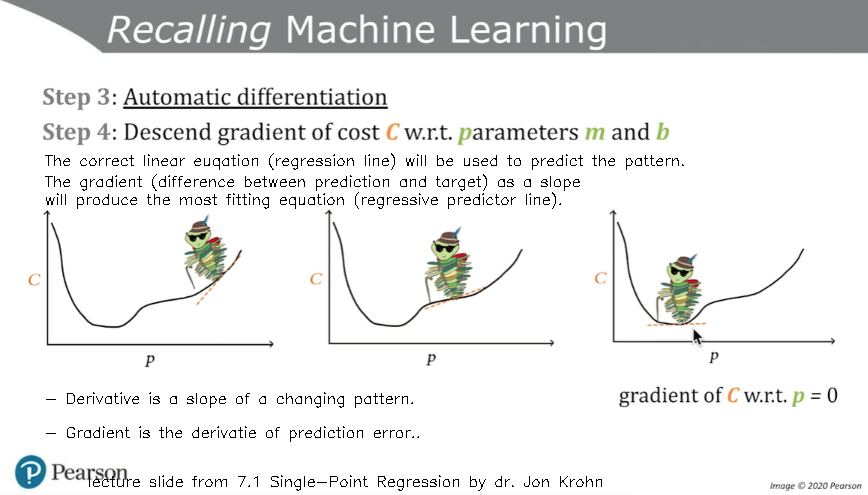

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/cost func.png"
img = get_img(path, resize=(0.75, 0.75))
img = cite_source(img, "lecture slide from 7.1 Single-Point Regression by dr. Jon Krohn", scale=0.5)
img = take_notes(img, "The correct linear euqation (regression line) will be used to predict the pattern.", org=(1/20,5/15), scale=0.5)
img = take_notes(img, "The gradient (difference between prediction and target) as a slope", org=(1/20,6/16), scale=0.5)
img = take_notes(img, "will produce the most fitting equation (regressive predictor line).", org=(1/20,7/17), scale=0.5)
img = take_notes(img, "- Derivative is a slope of a changing pattern.", org=(1/20,13/16), scale=0.5)
img = take_notes(img, "- Gradient is the derivatie of prediction error..", org=(1/20,15/17), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

So we are looking for a point where the slope becomes flat, because then it will make the whole $Cost$ 0 (cheap cheap!).

In [ ]:
xs = torch.tensor(np.arange(0, 8, 1))
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])
xs

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
def regression(x, m, b):
    return x * m + b

First, initialize $m$ and $b$ with the same "random" near-zero values.

In [ ]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

To keep the partial derivatives as simple as possible, let's move forward with a single instance $i$ from the eight possible data points:

In [ ]:
i = 7
x = xs[i]
y = ys[i]
x, y

(tensor(7), tensor(-1.3700))

### Step 1: Forward pass
We can flow the scalar tensor $x$ through our regression model to produce $\hat{y}$, an estimate of $y$. Prior to any model training, this is an arbitrary estimate:

In [ ]:
y_hat = regression(x, m, b)
y_hat   # the value is so and so (a random 6.4 instead of the correct target -1.37)
        # This is because we gave whatever values to m (0.9) and b (0.1) just to start the regression process.
        # in fact, we have NO IDEA if 0.9 and 0.1 are correct values :P 

tensor([6.4000], grad_fn=<AddBackward0>)

### Step 2: Get difference

Compare $\hat{y}$ with true $y$ to calculate cost $C$

In the Regression in PyTorch notebook, we used mean-squared error, which averages quadratic cost over multiple data points. With a single data point, here we can use quadratic cost alone. It is defined by:
$$ C = (\hat{y} - y)^2 $$

Prior to the model training, however, this $\hat y$ is NOT going to be close to the correct target $y$.

<br/>

Again (recap), why square the difference? 
- The difference remains always $positive$.
- The difference represents an exponentially ($^2$) bigger cost. 
    - The difference looks more striking when squared.

In [ ]:
# Quadratic cost = squared_error
def squared_error(y_hat, y):
    return (y_hat - y)**2

In [ ]:
C = squared_error(y_hat, y)
C

tensor([60.3729], grad_fn=<PowBackward0>)

### Step 3: Automatic differentiation
Calculate Gradient
Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [ ]:
C.backward() # this calculates the gradient of C for paramters. 
             # this class C backwarded by backward(), now has .grad values as its self.variables.

The partial derivative of $C$ with respect to $m$ ($\frac{\partial C}{\partial m}$) is:

In [ ]:
m.grad

tensor([108.7800])

And the partial derivative of $C$ with respect to $b$ ($\frac{\partial C}{\partial b}$) is:

In [ ]:
b.grad

tensor([15.5400])

## 7.2 Partial Derivatives of Quadratic Cost


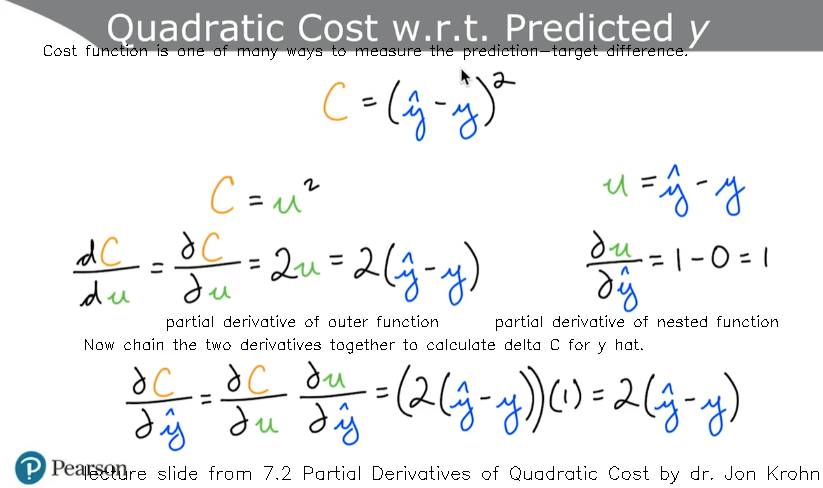

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/quadratic cost for y.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.6)
img = take_notes(img, "Cost function is one of many ways to measure the prediction-target difference.", org=(1/20,1/9 ), scale=0.5)
img = take_notes(img, "partial derivative of nested function", org=(6/10,2/3), scale=0.5)
img = take_notes(img, "partial derivative of outer function", org=(1/5,2/3), scale=0.5)
img = take_notes(img, "Now chain the two derivatives together to calculate delta C for y hat.", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

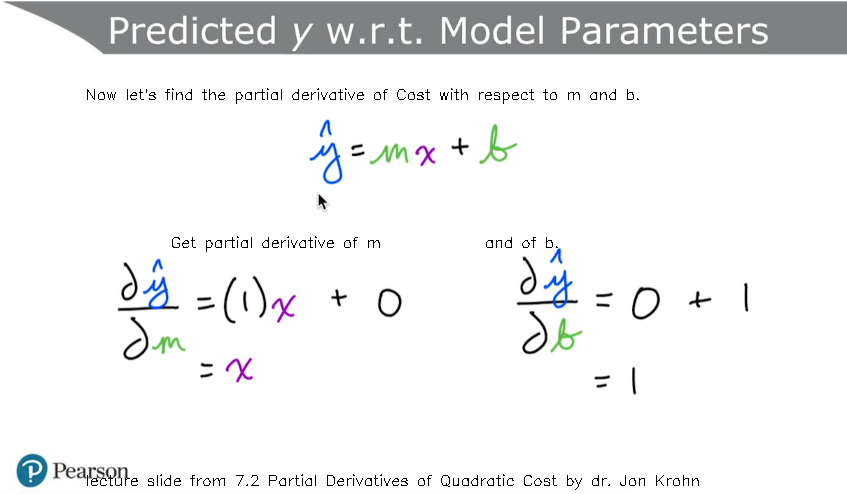

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/slope to chain.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.5)
img = take_notes(img, "Now let's find the partial derivative of Cost with respect to m and b.", org=(1/10,1/5), scale=0.5)
img = take_notes(img, "Get partial derivative of m", org=(1/5,1/2), scale=0.5)
img = take_notes(img, "and of b.", org=(4/7, 1/2), scale=0.5) 
#img = increase_brightness(img, value=75)
cv2_imshow(img)

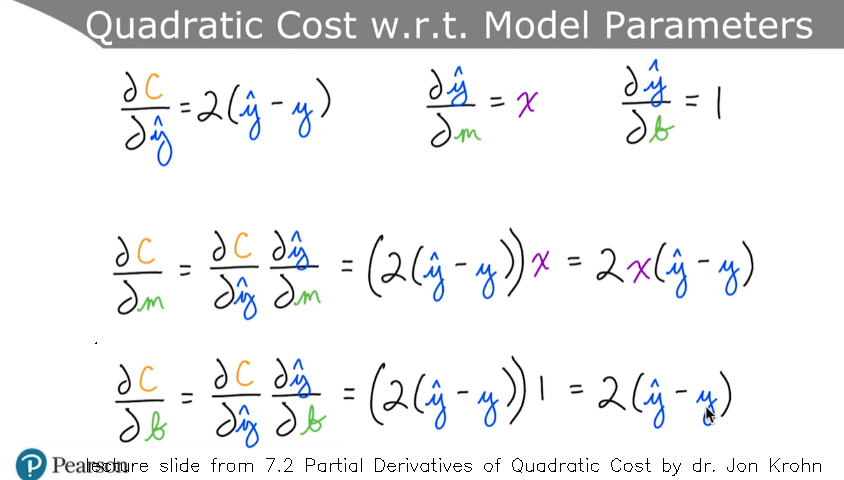

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/quadratic cost.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.6)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

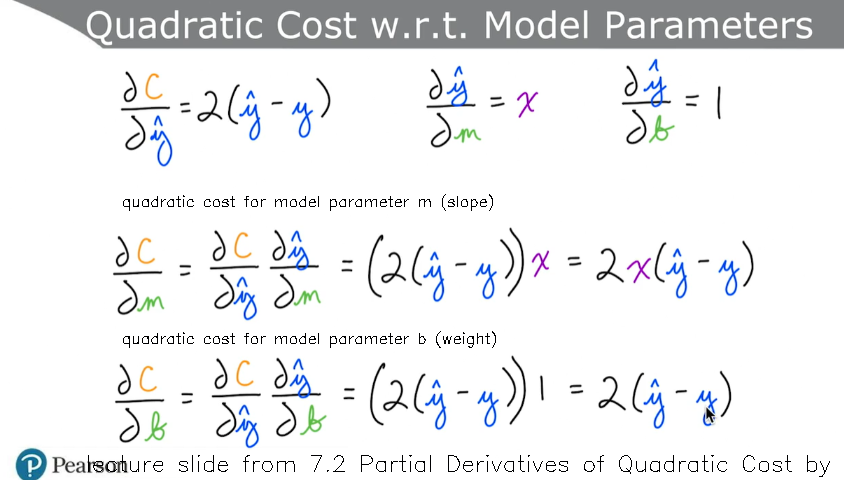

In [ ]:
# display work
path = "/content/here/MyDrive/Math works/quadratic cost.png"
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, "quadratic cost for model parameter m (slope)", org=(1/7,3/7), scale=0.5)
img = take_notes(img, "quadratic cost for model parameter b (weight)", org=(1/7,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

### Hands-on code demo

Return to Calculus II slides here to derive $\frac{\partial C}{\partial m}$ and $\frac{\partial C}{\partial b}$.

$$ \frac{\partial C}{\partial m} = 2x(\hat{y} - y) $$

In [ ]:
# partial derivative of prediction-target difference (which is essential the slope)
2 * x * (y_hat.item() - y)

tensor(108.7800)


$$ \frac{\partial C}{\partial b} = 2(\hat{y}-y) $$

In [ ]:
# partial derivative of bias (y-intercept in a linear equation)
2 * (y_hat.item() - y)

tensor(15.5400)

## 7.3 Descending the Gradient of Cost

The Gradient of Cost, $\nabla C$
The gradient of cost, which is symbolized $\nabla C$ (pronounced "nabla C"), is a vector of all the partial derivatives of $C$ with respect to each of the individual model parameters:


## 7.4 Gradient of Mean Squared Error


In [ ]:
# display work
path = ""
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)


$\nabla C = \nabla_p C = \left[ \frac{\partial{C}}{\partial{p_1}}, \frac{\partial{C}}{\partial{p_2}}, \cdots, \frac{\partial{C}}{\partial{p_n}} \right]^T $


In this case, there are only two parameters, $b$ and $m$:

$\nabla C = \left[ \frac{\partial{C}}{\partial{b}}, \frac{\partial{C}}{\partial{m}} \right]^T $

In [ ]:
gradient = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradient

tensor([[ 15.5400],
        [108.7800]])

In [ ]:
# display work
path = ""
img = get_img(path, resize=(0.7,0.7))
img = cite_source(img, "lecture slide from 7.2 Partial Derivatives of Quadratic Cost by dr. Jon Krohn", scale=0.75)
img = take_notes(img, " ", org=(1/5,2/3), scale=0.5)
img = take_notes(img, " .", org=(1/10,5/7), scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

### Gradient of Cost on a Batch of Data
- Calculate the gradient of mean squared error on a batch of data
- Visualize gradient descent in action

### Batch training
In ML, model is typically trained with data batches as it is much more efficient than training on a single point each time. 
- Training a model on a single data point doesn't take advatange of the memory / compute resources of your machine.
- However, the batch size shouldn't be too big either. Too large batch size risks skipping the global minimum of cost with respect to the model parameters.

In [24]:
xs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.])
ys = torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37])

In [26]:
def regression(x, m, b):
    return m * x + b

In [27]:
m = torch.tensor([1.9]).requires_grad_()
b = torch.tensor([0.2]).requires_grad_()

### Step 1: Forward pass

In [28]:
y_hats = regression(xs, m, b)
y_hats

tensor([ 0.2000,  2.1000,  4.0000,  5.9000,  7.8000,  9.7000, 11.6000, 13.5000],
       grad_fn=<AddBackward0>)

### Step 2: Compare $\hat{y}$ with true $y$ to calculate cost $C$

Let's use mean squared error, which averages quadratic cost across multiple data points: $$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

In [22]:
def mse(y_hat, y): 
    sigma = torch.sum((y_hat - y) ** 2)
    return sigma / len(y)

In [29]:
C = mse(y_hats, ys)
C

tensor(74.8170, grad_fn=<DivBackward0>)

### Step 3**: Use autodiff to calculate gradient of $C$ w.r.t. parameters

In [30]:
C.backward()
m.grad, b.grad

(tensor([72.0050]), tensor([13.4650]))

Compare these grad values with the below Step 3 Manual calculation. 
The gradients are partial derivaties of variables from the model equation. They have the same value...!

Biw let's derive $\frac{\partial C}{\partial m}$ and $\frac{\partial C}{\partial b}$.


$$ \frac{\partial C}{\partial m} = \frac{2}{n} \sum (\hat{y}_i - y_i) \cdot x_i $$

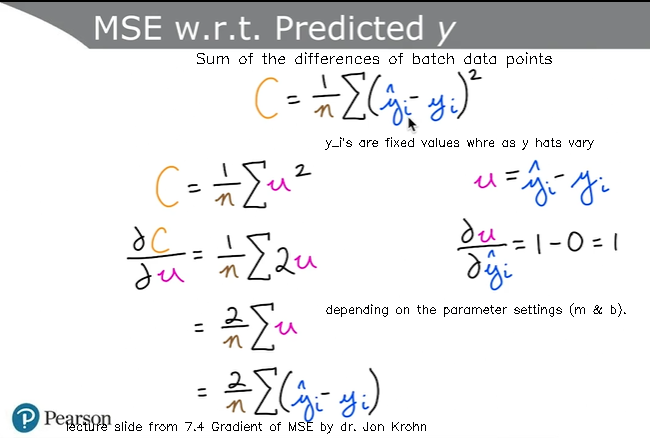

In [ ]:
path = "/content/here/MyDrive/Math works/cost of batch.png"
img = get_img(path)
img = cite_source(img, "lecture slide from 7.4 Gradient of MSE by dr. Jon Krohn", scale=0.4)
img = take_notes(img, "Sum of the differences of batch data points", org=(3/10,1/7), scale=0.5)
img = take_notes(img, "y_i's are fixed values whre as y hats vary", org=(1/2,6/18), scale=0.4)
img = take_notes(img, "depending on the parameter settings (m & b).", org=(1/2,5/7), scale=0.4)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

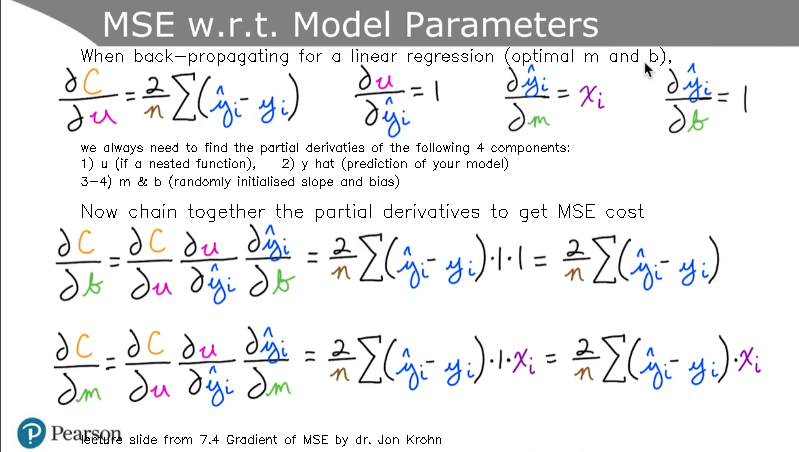

In [ ]:
path = "/content/here/MyDrive/Math works/full derivative for a batch.png"
img = get_img(path, resize=0.65)
img = cite_source(img, "lecture slide from 7.4 Gradient of MSE by dr. Jon Krohn", scale=0.4)
img = take_notes(img, "When back-propagating for a linear regression (optimal m and b),", org=(1/10,2/15), scale=0.55)
img = take_notes(img, "we always need to find the partial derivaties of the following 4 components:", org=(1/10,6/18), scale=0.4)
img = take_notes(img, "1) u (if a nested function),    2) y hat (prediction of your model)", org=(1/10,7/19), scale=0.4)
img = take_notes(img, "3-4) m & b (randomly initialised slope and bias)", org=(1/10,9/22), scale=0.4)
img = take_notes(img, "Now chain together the partial derivatives to get MSE cost", org=(1/10,11/23), scale=0.6)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

#### Step 3: Manual Calculation - Compare!

$$ \frac{\partial C}{\partial m} = \frac{2}{n} \sum (\hat{y}_i - y_i) \cdot x_i $$

In [31]:
2 / len(ys) * torch.sum((y_hats - ys) * xs)

tensor(72.0050, grad_fn=<MulBackward0>)

$$ \frac{\partial C}{\partial b} = \frac{2}{n} \sum (\hat{y}_i - y_i) $$

In [32]:
2 / len(ys) * torch.sum(y_hats - ys)

tensor(13.4650, grad_fn=<MulBackward0>)

#### Create gradient with Torch


In [33]:
gradients = torch.tensor([[b.grad.item(), m.grad.item()]]).T
gradients

tensor([[13.4650],
        [72.0050]])

Let's visualize the most pertinent metrics in a single plot:

In [34]:
# plot code by dr. Jon Krohn

def labeled_regression_plot(x, y, m, b, C, include_grad=True):
    
    title = 'Cost = {}'.format('%.3g' % C.item())
    if include_grad:
        xlabel = 'm = {},   m grad = {}'.format('%.3g' % m.item(), '%.3g' % m.grad.item())
        ylabel = 'b = {},   b grad = {}'.format('%.3g' % b.item(), '%.3g' % b.grad.item())
    else:
        xlabel = 'm = {}'.format('%.3g' % m.item())        
        ylabel = 'b = {}'.format('%.3g' % b.item())
    
    fig, ax = plt.subplots()
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    ax.scatter(x, y, zorder=3)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, m, b)
    y_max = regression(x_max, m, b)

    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max], c='C01')

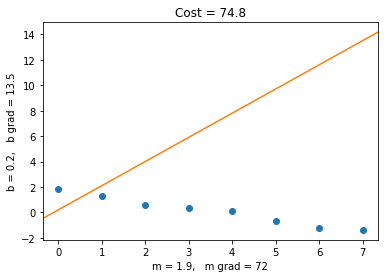

In [35]:
labeled_regression_plot(xs, ys, m, b, C)

### Step 4: Gradient descent

$\frac{\partial C}{\partial m} = 36.3$ indicates that an increase in $m$ corresponds to a large increase in $C$. 

Meanwhile, $\frac{\partial C}{\partial b} = 6.26$ indicates that an increase in $b$ also corresponds to an increase in $C$, though much less so than $m$.

In the first round of training, the lowest hanging fruit with respect to reducing cost $C$ is therefore to decrease the slope of the regression line, $m$. There will also be a relatively small decrease in the $y$-intercept of the line, $b$. 

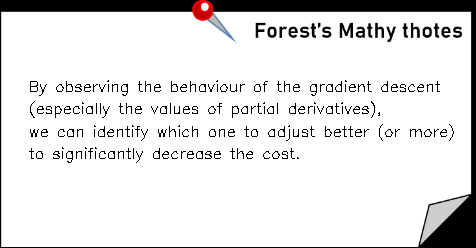

In [84]:
notes = ["By observing the behaviour of the gradient descent", 
         "(especially the values of partial derivatives),", 
         "we can identify which one to adjust better (or more)", 
         "to significantly decrease the cost."]

post_it(notes)

In [36]:
optimizer = torch.optim.SGD([m, b], lr=0.01)
optimizer.step()

In [37]:
C = mse(regression(xs, m, b), ys)
C

tensor(30.9268, grad_fn=<DivBackward0>)

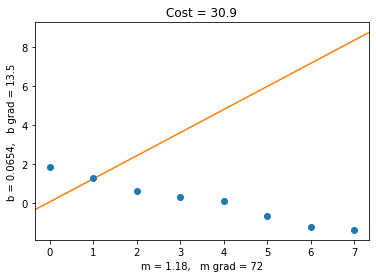

In [38]:
labeled_regression_plot(xs, ys, m, b, C, include_grad=True)

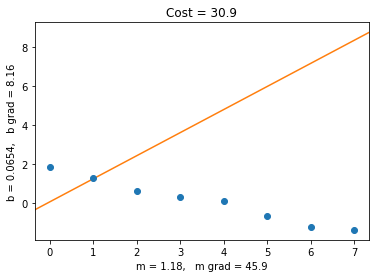

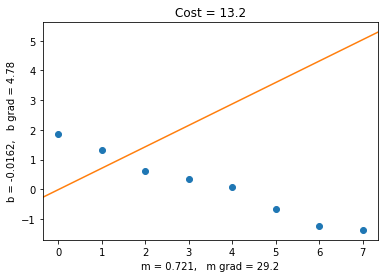

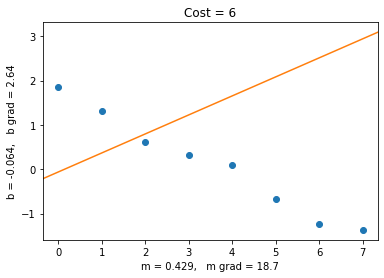

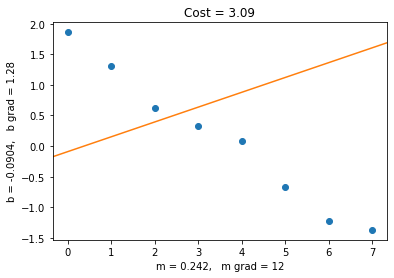

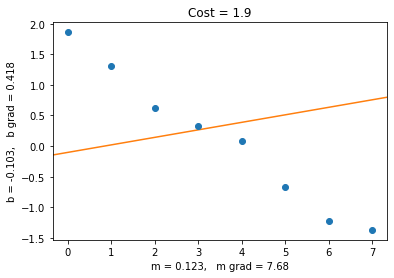

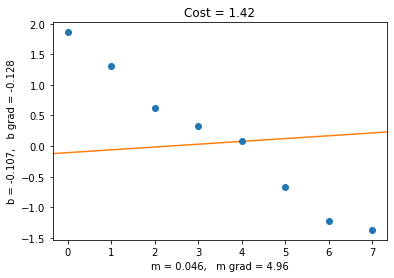

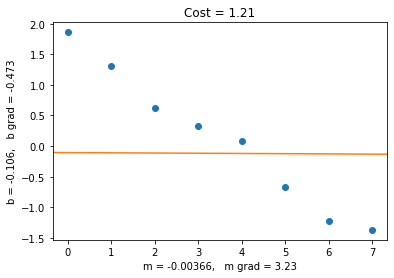

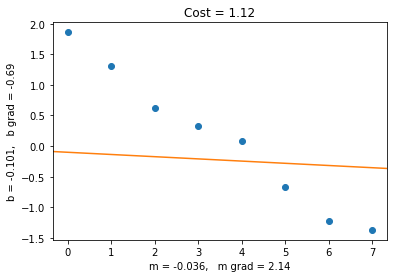

In [39]:
epochs = 8
for epoch in range(epochs):
    
    optimizer.zero_grad()        # Reset gradients to zero; else they accumulate
    
    y_hats = regression(xs, m, b) # Step 1
    C = mse(y_hats, ys)           # Step 2   Calculate our cost.    
    C.backward()                 # Step 3
    
    labeled_regression_plot(xs, ys, m, b, C)
    optimizer.step()             # Step 4

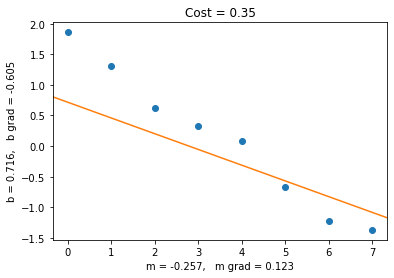

In [40]:
epochs = 100
for epoch in range(epochs):
    
    optimizer.zero_grad()        # Reset gradients to zero; else they accumulate
    
    y_hats = regression(xs, m, b) # Step 1
    C = mse(y_hats, ys)           # Step 2   Calculate our cost.    
    C.backward()                 # Step 3
    optimizer.step()             # Step 4

labeled_regression_plot(xs, ys, m, b, C)

cost:  tensor(0.3467, grad_fn=<DivBackward0>)
cost:  tensor(0.3429, grad_fn=<DivBackward0>)
cost:  tensor(0.3392, grad_fn=<DivBackward0>)
cost:  tensor(0.3355, grad_fn=<DivBackward0>)
cost:  tensor(0.3319, grad_fn=<DivBackward0>)
cost:  tensor(0.3283, grad_fn=<DivBackward0>)
cost:  tensor(0.3247, grad_fn=<DivBackward0>)
cost:  tensor(0.3212, grad_fn=<DivBackward0>)
cost:  tensor(0.3177, grad_fn=<DivBackward0>)
cost:  tensor(0.3143, grad_fn=<DivBackward0>)
cost:  tensor(0.3109, grad_fn=<DivBackward0>)
cost:  tensor(0.3076, grad_fn=<DivBackward0>)
cost:  tensor(0.3043, grad_fn=<DivBackward0>)
cost:  tensor(0.3010, grad_fn=<DivBackward0>)
cost:  tensor(0.2977, grad_fn=<DivBackward0>)
cost:  tensor(0.2945, grad_fn=<DivBackward0>)
cost:  tensor(0.2914, grad_fn=<DivBackward0>)
cost:  tensor(0.2883, grad_fn=<DivBackward0>)
cost:  tensor(0.2852, grad_fn=<DivBackward0>)
cost:  tensor(0.2821, grad_fn=<DivBackward0>)
cost:  tensor(0.2791, grad_fn=<DivBackward0>)
cost:  tensor(0.2761, grad_fn=<Div

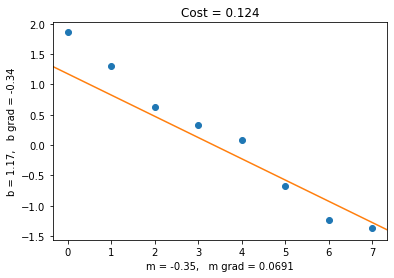

In [41]:
epochs = 100
for epoch in range(epochs):
    
    optimizer.zero_grad()        # Reset gradients to zero; else they accumulate
    
    y_hats = regression(xs, m, b) # Step 1
    C = mse(y_hats, ys)           # Step 2   Calculate our cost.    
    print('cost: ', C)
    C.backward()                 # Step 3
    optimizer.step()             # Step 4

labeled_regression_plot(xs, ys, m, b, C)

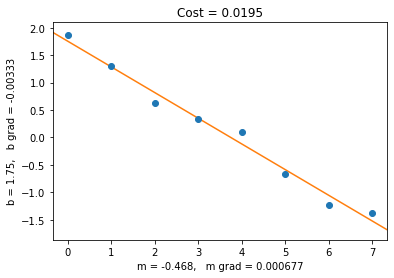

In [42]:
epochs = 800
for epoch in range(epochs):
    
    optimizer.zero_grad()        # Reset gradients to zero; else they accumulate
    
    y_hats = regression(xs, m, b) # Step 1
    C = mse(y_hats, ys)           # Step 2   Calculate our cost.    
    C.backward()                 # Step 3
    optimizer.step()             # Step 4

labeled_regression_plot(xs, ys, m, b, C)

## 7.5 Backpropagation



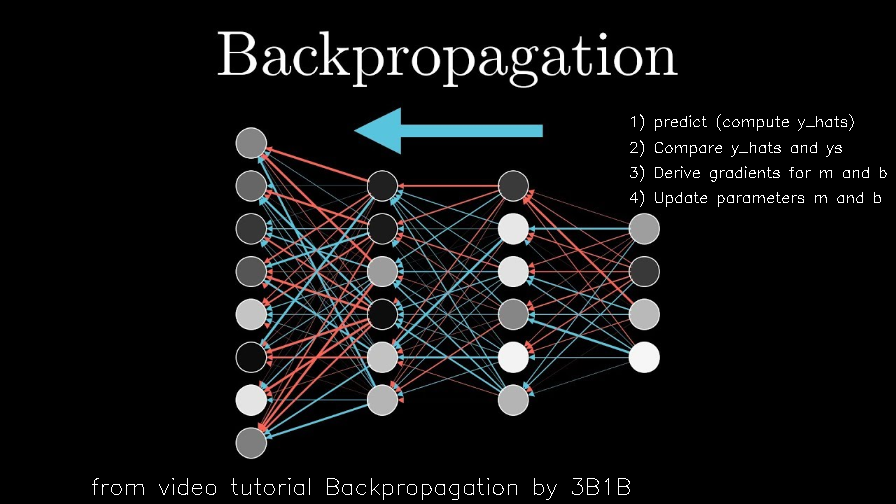

In [74]:
back_steps = ["1) predict (compute y_hats)",
           "2) Compare y_hats and ys",
           "3) Derive gradients for m and b",
           "4) Update parameters m and b"]

path = "/content/here/MyDrive/Math works/backpropagation.jpg"
img = get_img(path, resize=0.7)
img = cite_source(img, "from video tutorial Backpropagation by 3B1B", color=(255,255,255), scale=0.75)
for i, step in enumerate(back_steps):
    img = take_notes(img, step, org=(7/10,(i+5)/20), scale=0.5, color=(255, 255, 255), thickness=1)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

## 7.6 Higher-Order Partial Derivatives
First order partial derivatives   
Example)
$$z = x^2 + 5xy + 2y^2$$

$$\frac{\delta z}{\delta x} = 2x + 5y(1) + 0 = 2x + 5y$$
$$\frac{\delta z}{\delta y} = 0 + 5x(1) + 2(2y) = 5x + 4y$$

<br/>

Second-order partial derivatives  
$\frac{\delta z}{\delta x} = 2x + 5y$, &emsp;  $\frac{\delta z}{\delta y} = 5x + 4y$

Below calculates an example which gives a total of 4 second-order partial derivatives. 


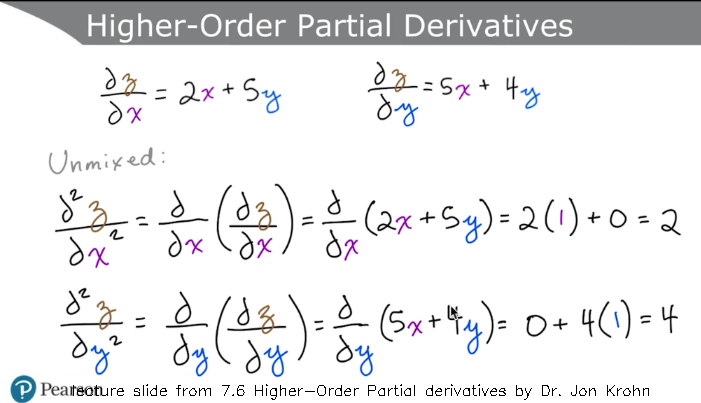

In [89]:
path = "/content/here/MyDrive/Math works/second order partial derivatives.png"
img = get_img(path, resize=0.7)
img = cite_source(img, "lecture slide from 7.6 Higher-Order Partial derivatives by Dr. Jon Krohn", scale=0.5)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

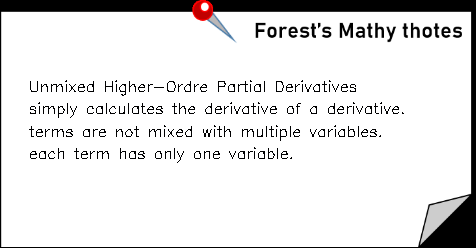

In [87]:
notes = ["Unmixed Higher-Ordre Partial Derivatives",
         "simply calculates the derivative of a derivative.",
         "terms are not mixed with multiple variables.",
         "each term has only one variable."]
post_it(notes)

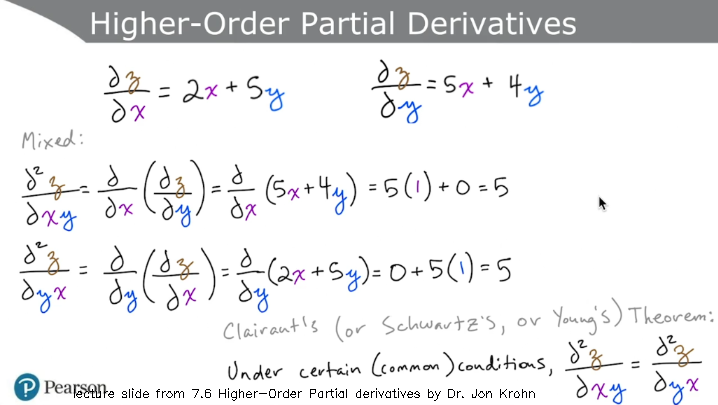

In [93]:
path = "/content/here/MyDrive/Math works/mixed second order partial derivatives.png"
img = get_img(path, resize=0.7)
img = cite_source(img, "lecture slide from 7.6 Higher-Order Partial derivatives by Dr. Jon Krohn", scale=0.4)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

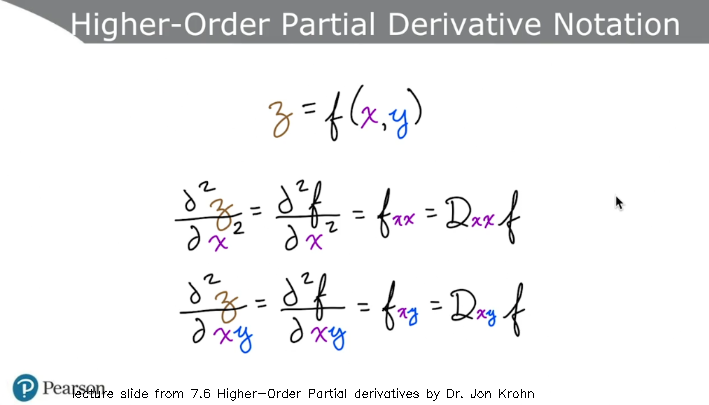

In [94]:
path = "/content/here/MyDrive/Math works/higher order notations.png"
img = get_img(path, resize=0.7)
img = cite_source(img, "lecture slide from 7.6 Higher-Order Partial derivatives by Dr. Jon Krohn", scale=0.4)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

## 7.7 Exercise
Find all the second-order partial derivatives of $z=x^3 + 2xy$.

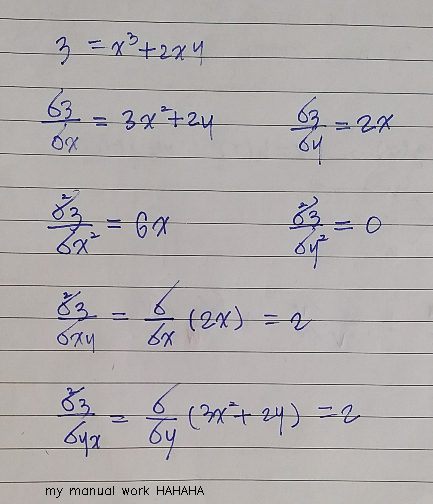

In [98]:
path = "/content/here/MyDrive/Math works/ex77 answer.jpg"
img = get_img(path, resize=0.175)
img = cite_source(img, "my manual work HAHAHA", scale=0.4)
#img = increase_brightness(img, value=75)
cv2_imshow(img)

# Frequent Functions
- ```C.backward()```  
- ```optimizer.step()```  